In [39]:
import sys

sys.path.append('~/PROTAC-Degradation-Predictor/protac_degradation_predictor')
sys.path.append('~/PROTAC-Degradation-Predictor')

import protac_degradation_predictor as pdp

import os
from collections import defaultdict

from rdkit import DataStructs
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the PROTAC dataset
active_col = 'Active (Dmax 0.6, pDC50 6.0)'

# Get Dmax_threshold from the active_col
Dmax_threshold = float(active_col.split('Dmax')[1].split(',')[0].strip('(').strip(')').strip())
pDC50_threshold = float(active_col.split('pDC50')[1].strip('(').strip(')').strip())

protac_df = pd.read_csv('~/PROTAC-Degradation-Predictor/data/PROTAC-Degradation-DB.csv')
# Map E3 Ligase Iap to IAP
protac_df['E3 Ligase'] = protac_df['E3 Ligase'].str.replace('Iap', 'IAP')
protac_df[active_col] = protac_df.apply(
    lambda x: pdp.is_active(
        x['DC50 (nM)'],
        x['Dmax (%)'],
        pDC50_threshold=pDC50_threshold,
        Dmax_threshold=Dmax_threshold,
    ),
    axis=1
)
protac_df.head()

,Compound ID,Uniprot,Smiles,E3 Ligase,InChI,InChI Key,Molecular Weight,Heavy Atom Count,Ring Count,Rotatable Bond Count,...,Assay (DC50/Dmax),Exact Mass,XLogP3,Target (Parsed),POI Sequence,E3 Ligase Uniprot,E3 Ligase Sequence,Cell Line Identifier,Active - OR,"Active (Dmax 0.6, pDC50 6.0)"
0,1,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C73H88ClF3N10O10S4/c1-47(49-13-15-51(...,SXPDUCVNMGMWBJ-FMZBIETASA-N,1486.282,101,10,24,...,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4,NaN,NaN
1,2,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C74H90ClF3N10O10S4/c1-48(50-13-15-52(...,HQKUMELJMUNTTF-NMKDNUEVSA-N,1500.309,102,10,25,...,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4,NaN,NaN
2,3,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C75H92ClF3N10O10S4/c1-49(51-16-18-53(...,ATQCEJKUPSBDMA-QARNUTPLSA-N,1514.336,103,10,26,...,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4,NaN,NaN
3,4,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C76H94ClF3N10O10S4/c1-50(52-17-19-54(...,FNKQAGMHNFFSEI-DTTPTBRMSA-N,1528.363,104,10,27,...,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4,NaN,NaN
4,5,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C77H96ClF3N10O10S4/c1-51(53-18-20-55(...,PXVFFBGSTYQHRO-REQIQPEASA-N,1542.390,105,10,28,...,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4,True,True


In [3]:
def get_smiles2fp_and_avg_tanimoto(protac_df: pd.DataFrame) -> tuple:
    """ Get the SMILES to fingerprint dictionary and the average Tanimoto similarity.
    
    Args:
        protac_df (pd.DataFrame): The DataFrame containing the PROTACs.
    
    Returns:
        tuple: The SMILES to fingerprint dictionary and the average Tanimoto similarity.
    """
    unique_smiles = protac_df['Smiles'].unique().tolist()

    smiles2fp = {}
    for smiles in tqdm(unique_smiles, desc='Precomputing fingerprints'):
        smiles2fp[smiles] = pdp.get_fingerprint(smiles)

    # # Get the pair-wise tanimoto similarity between the PROTAC fingerprints
    # tanimoto_matrix = defaultdict(list)
    # for i, smiles1 in enumerate(tqdm(protac_df['Smiles'].unique(), desc='Computing Tanimoto similarity')):
    #     fp1 = smiles2fp[smiles1]
    #     # TODO: Use BulkTanimotoSimilarity for better performance
    #     for j, smiles2 in enumerate(protac_df['Smiles'].unique()[i:]):
    #         fp2 = smiles2fp[smiles2]
    #         tanimoto_dist = 1 - DataStructs.TanimotoSimilarity(fp1, fp2)
    #         tanimoto_matrix[smiles1].append(tanimoto_dist)
    # avg_tanimoto = {k: np.mean(v) for k, v in tanimoto_matrix.items()}
    # protac_df['Avg Tanimoto'] = protac_df['Smiles'].map(avg_tanimoto)


    tanimoto_matrix = defaultdict(list)
    fps = list(smiles2fp.values())

    # Compute all-against-all Tanimoto similarity using BulkTanimotoSimilarity
    for i, (smiles1, fp1) in enumerate(tqdm(zip(unique_smiles, fps), desc='Computing Tanimoto similarity', total=len(fps))):
        similarities = DataStructs.BulkTanimotoSimilarity(fp1, fps[i:])  # Only compute for i to end, avoiding duplicates
        for j, similarity in enumerate(similarities):
            distance = 1 - similarity
            tanimoto_matrix[smiles1].append(distance)  # Store as distance
            if i != i + j:
                tanimoto_matrix[unique_smiles[i + j]].append(distance)  # Symmetric filling

    # Calculate average Tanimoto distance for each unique SMILES
    avg_tanimoto = {k: np.mean(v) for k, v in tanimoto_matrix.items()}
    protac_df['Avg Tanimoto'] = protac_df['Smiles'].map(avg_tanimoto)

    smiles2fp = {s: np.array(fp) for s, fp in smiles2fp.items()}

    return smiles2fp, protac_df

smiles2fp, protac_df = get_smiles2fp_and_avg_tanimoto(protac_df)

Computing Tanimoto similarity: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1467/1467 [00:00<00:00, 3748.38it/s]


In [4]:
# Load embedding dictionaries
protein2embedding = pdp.load_protein2embedding('../data/uniprot2embedding.h5')
cell2embedding = pdp.load_cell2embedding('../data/cell2embedding.pkl')

In [53]:
protac_ds = pdp.protac_dataset.PROTAC_Dataset(
    protac_df[protac_df[active_col].notna()].copy(),
    protein2embedding,
    cell2embedding,
    smiles2fp,
    active_label=active_col,
)
scalers = protac_ds.fit_scaling()
# protac_ds.apply_scaling(scalers)
protac_ds.data.head()
scalers

{'Smiles': StandardScaler(),
 'Uniprot': StandardScaler(),
 'E3 Ligase Uniprot': StandardScaler(),
 'Cell Line Identifier': StandardScaler()}

In [58]:
all, _ = protac_ds.get_numpy_arrays()
smiles, _ = protac_ds.get_numpy_arrays('Smiles')
smiles.shape

(857, 256)

In [34]:
# Import minmax scaler
from sklearn.preprocessing import MinMaxScaler

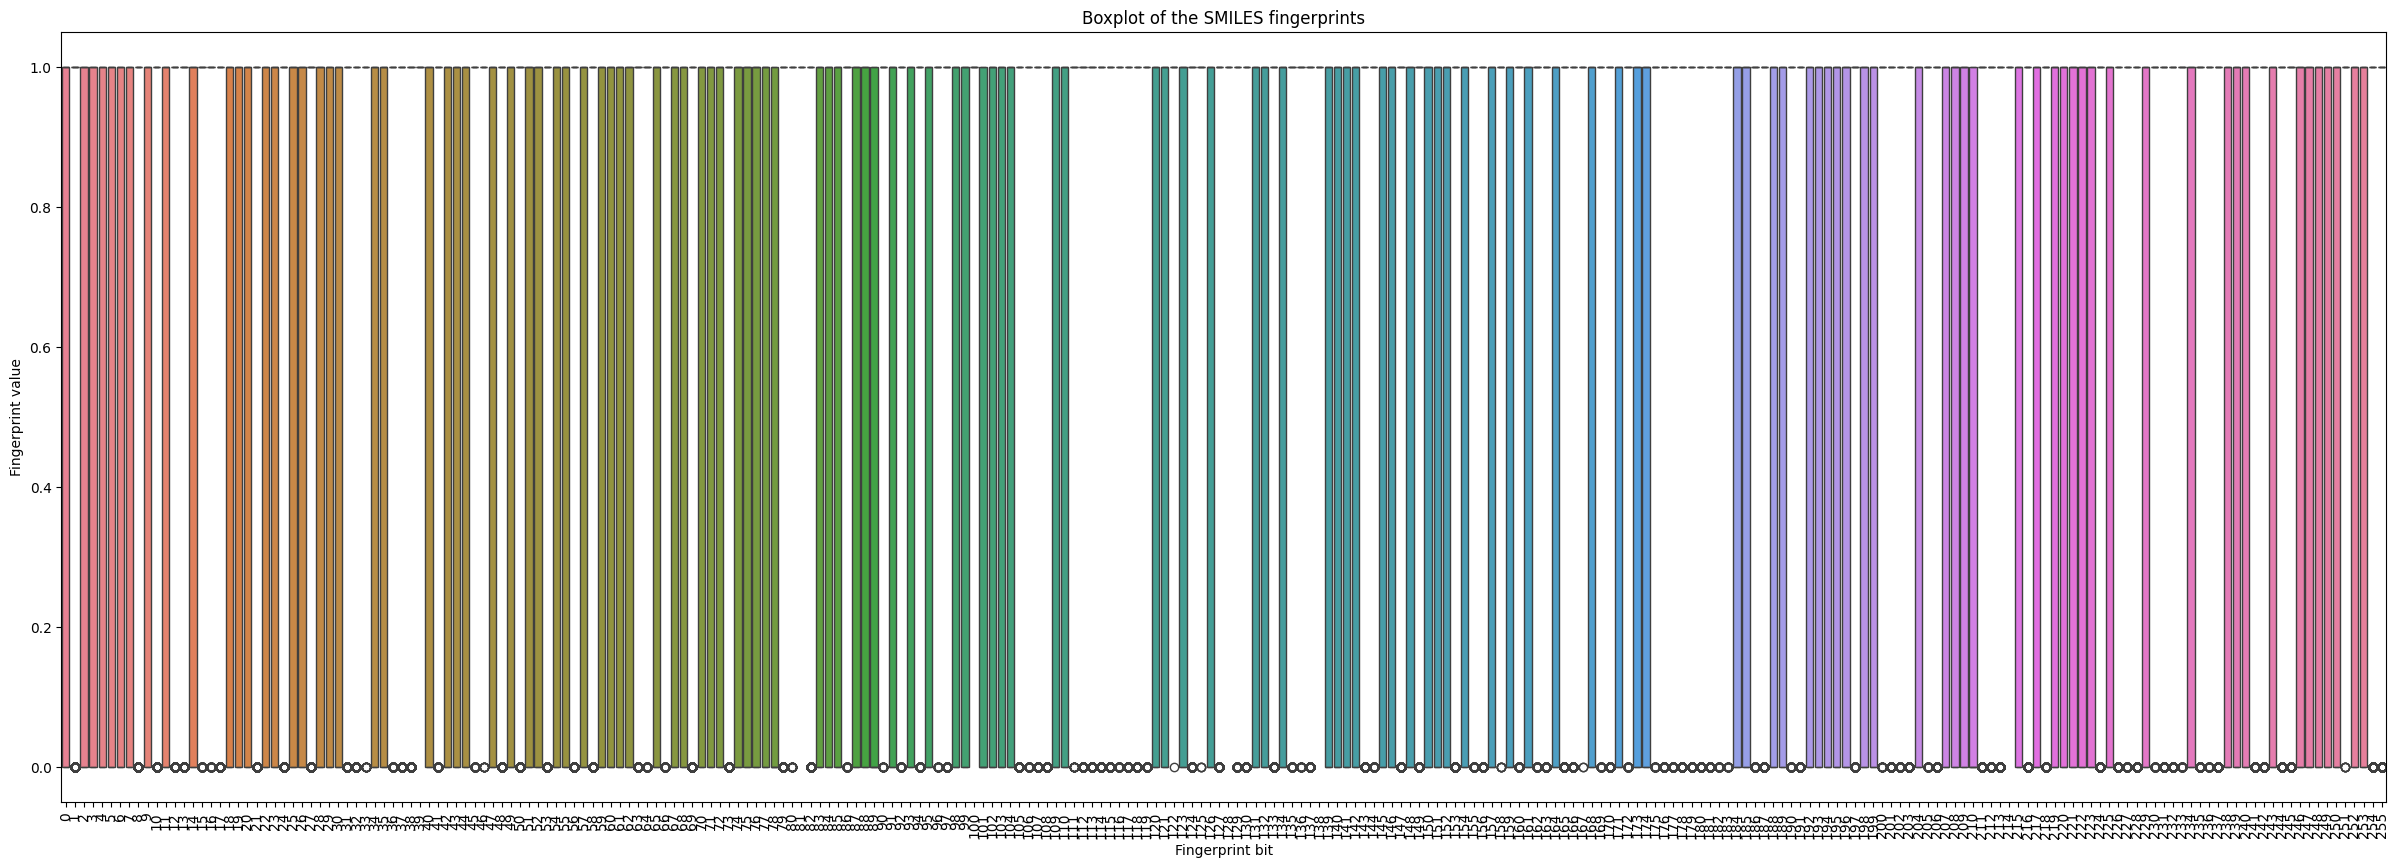

In [59]:
# Plot whisker plot of the smiles array in seaborn
plt.figure(figsize=(30, 10))
sns.boxplot(smiles)
plt.title('Boxplot of the SMILES fingerprints')
plt.xlabel('Fingerprint bit')
plt.ylabel('Fingerprint value')
# Rotate x-axis labels
plt.xticks(rotation=90)
plt.show()

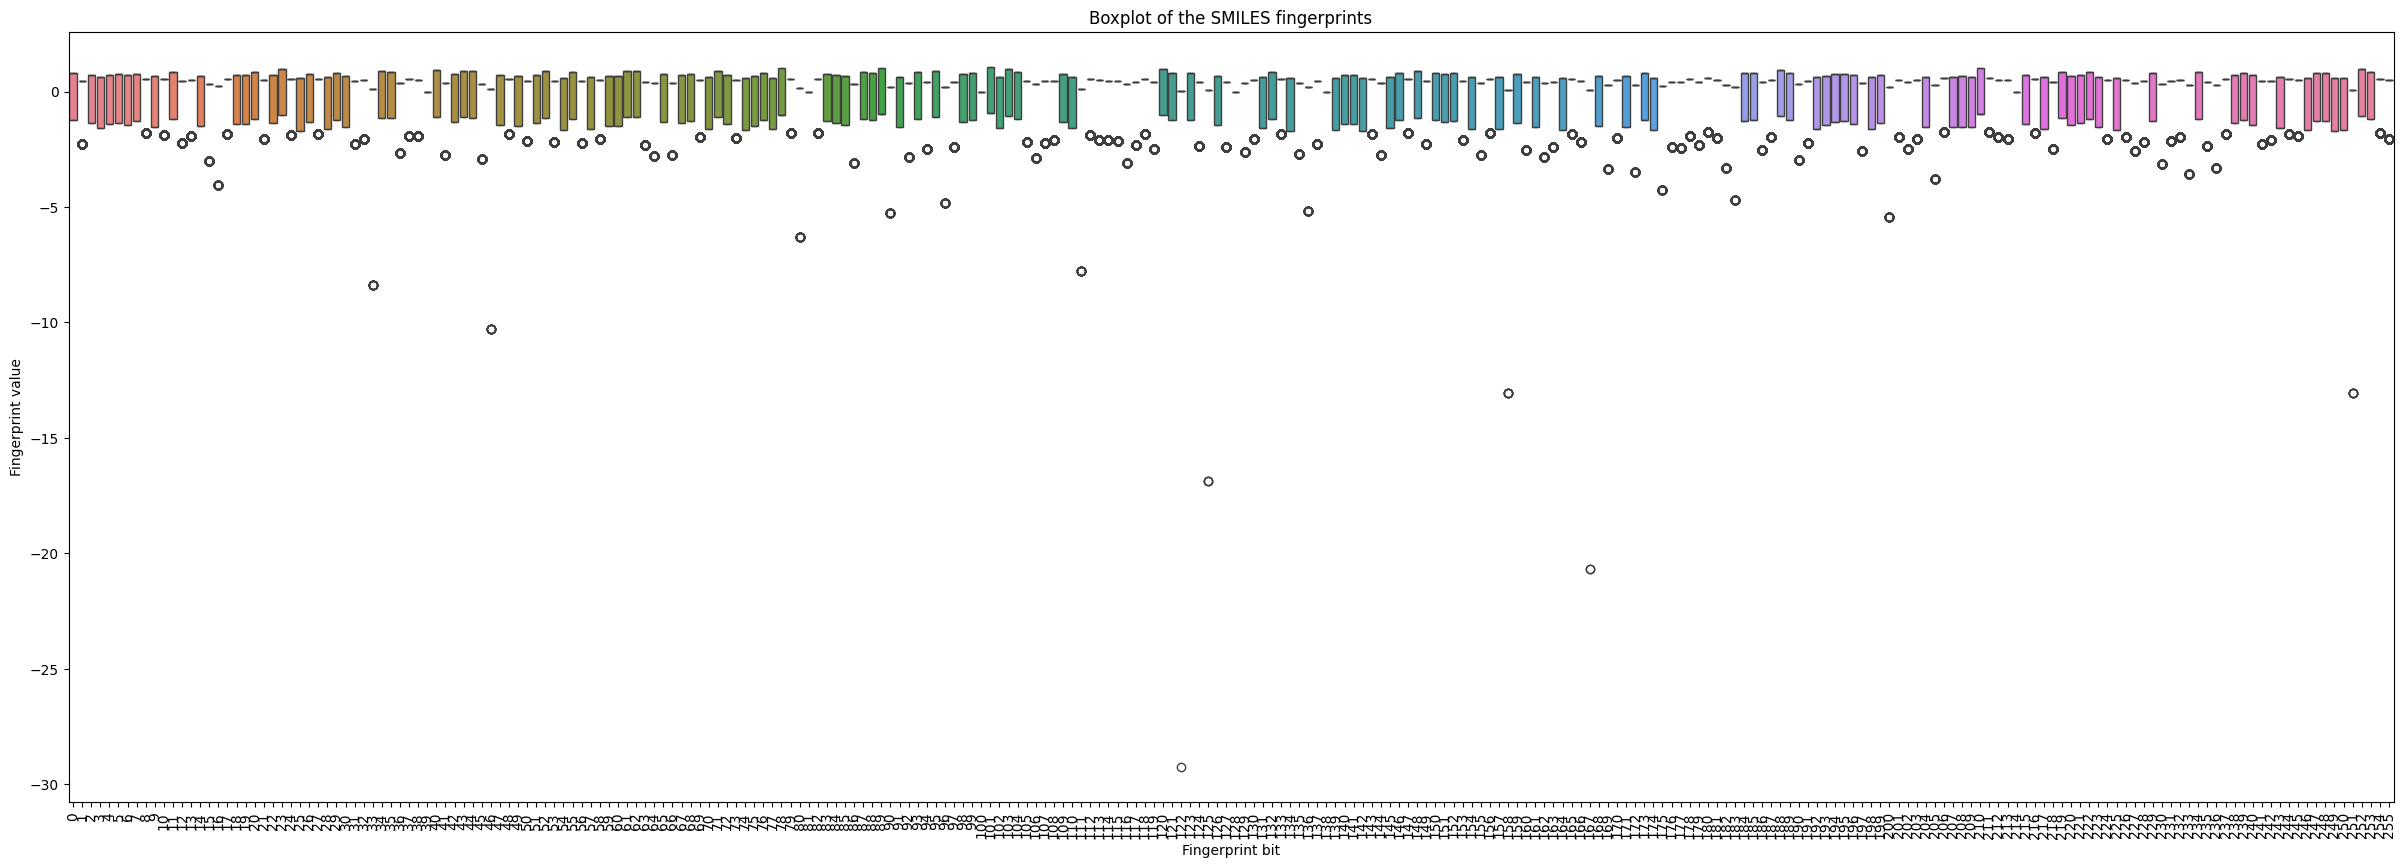

In [60]:
scaled_smiles = scalers['Smiles'].transform(smiles)

plt.figure(figsize=(30, 10))
sns.boxplot(scaled_smiles)
plt.title('Boxplot of the SMILES fingerprints')
plt.xlabel('Fingerprint bit')
plt.ylabel('Fingerprint value')
# Rotate x-axis labels
plt.xticks(rotation=90)
plt.show()

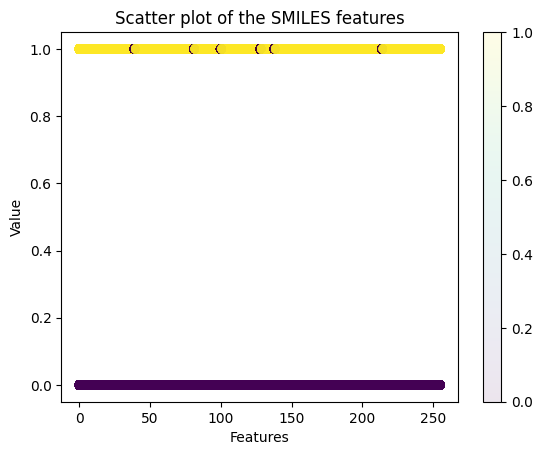

In [35]:
# Plot a scatter plot the smiles features (the smiles array is (samples, features))
num_samples = smiles.shape[0]

for i in range(smiles.shape[1]):
    plt.scatter([i] * num_samples, smiles[:, i], alpha=0.1, c=smiles[:, i], cmap='viridis')
plt.xlabel('Features')
plt.ylabel('Value')
# Plot the colorbar in the same color map (viridis)
plt.colorbar()
plt.title('Scatter plot of the SMILES features')
plt.show()

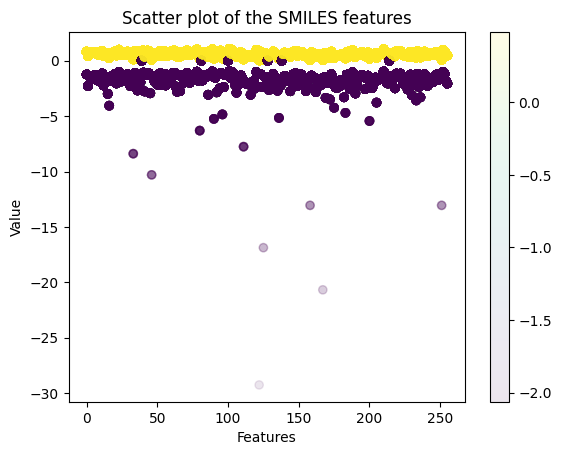

In [38]:
scaled_smiles = scalers['Smiles'].transform(smiles)
# scaled_smiles = MinMaxScaler().fit_transform(scaled_smiles)
for i in range(scaled_smiles.shape[1]):
    # Viridis palette
    plt.scatter([i] * num_samples, scaled_smiles[:, i], alpha=0.1, c=scaled_smiles[:, i], cmap='viridis')
plt.xlabel('Features')
plt.ylabel('Value')
plt.colorbar()
plt.title('Scatter plot of the SMILES features')
plt.show()


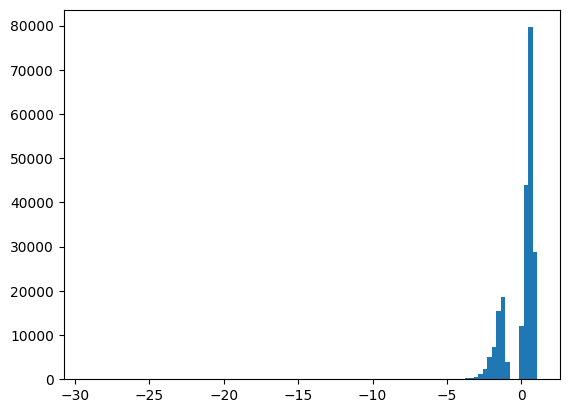

In [15]:
# Plot the distribution of te smiles array
import matplotlib.pyplot as plt

plt.hist(scalers['Smiles'].transform(smiles).flatten(), bins=100)
plt.show()